symbols:  [ 1  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1
  1  1  1  1 -1 -1  1  1 -1 -1  1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1
  1 -1]
channel output:  [ 0.9  1.3 -0.4 -1.3 -1.3 -1.3 -1.3 -1.3  0.4  1.3  1.3  1.3  1.3  1.3
  1.3  1.3  1.3 -0.4  0.4 -0.4  0.4  1.3 -0.4  0.4  1.3  1.3  1.3  1.3
 -0.4 -1.3  0.4  1.3 -0.4 -1.3  0.4  1.3  1.3  1.3  1.3 -0.4 -1.3  0.4
  1.3 -0.4  0.4 -0.4  0.4 -0.4  0.4 -0.4]
ZF equalizer output:  [ 1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
  1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.
  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1.]
decided symbols:  [ 1  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1
  1  1  1  1 -1 -1  1  1 -1 -1  1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1
  1 -1]
SER = 0.00e+00
SER ZF = 0.00e+00


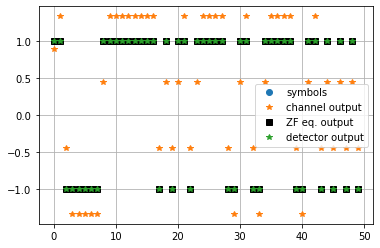

In [1]:
import numpy as np
from scipy import signal
from numpy.random import randint
import matplotlib.pyplot as plt

N = 50  # length of transmitting sequence
s = (-1) ** (np.floor(2 * np.random.rand(N)))  # creating PAM symbols

Es = np.mean(s**2)
s = s/np.sqrt(Es)

# Sending Through the Channel
h = np.array([0.815, 0.407])  # channel with finite impulse response
h = h / np.sqrt(np.sum(h**2)) # normalize impulse response

x = np.convolve(h, s,'same')

# Adding Noise
SNRdB = 100
σ = np.sqrt(1 / (10 ** (SNRdB / 10)))
n = np.random.normal(0, σ, len(x))
y = x + n

# Linear Zero Forcing at the Receiver
h_tf = signal.TransferFunction(h, 1)
h_ZF_num, h_ZF_den = h_tf.den, h_tf.num
xh = signal.lfilter(h_ZF_num, h_ZF_den, y)
#xh = np.roll(xh,1)

# detector (hard decisions)
xd = np.zeros(xh.shape, dtype=int)
xd[xh > 0] = 1
xd[xh < 0] = -1

plt.plot(s,'o', label='symbols')
plt.plot(x,'*', label='channel output')
plt.plot(xh,'ks', label='ZF eq. output')
plt.plot(xd,'*', label='detector output')
plt.legend()
plt.grid()

discard = 10

print('symbols: ', s.astype(int))
print('channel output: ',np.round(x,1))
print('ZF equalizer output: ',np.round(xh,1))
print('decided symbols: ',xd.astype(int))
print(f'SER = {np.mean((s[discard:-discard]>0)^(y[discard:-discard]>0)):.2e}')
print(f'SER ZF = {np.mean((s[1:]>0)^(xd[1:]>0)):.2e}')

In [2]:
import numpy as np
from scipy.linalg import toeplitz

def mmseEq(y, h, noiseVar, M, L):
    """
    Perform Minimum Mean Square Error (MMSE) equalization on a received signal.

    Parameters:
    ----------
    y : ndarray
        1-D numpy array representing the received signal.
    h : ndarray
        1-D numpy array representing the impulse response of the channel.
    noiseVar : float
        Scalar value representing the noise variance.
    M : int
        Filter length.
    L : int
        Length parameter.

    Returns:
    -------
    xh : ndarray
        1-D numpy array representing the MMSE equalized signal.
    """

    h[-1::-1] = h  # Reverse the order of elements in the h array

    # MMSE equalization
    d = np.ceil(((M + L) - 1) / 2).astype(np.int64)  # Calculate d as the ceiling of ((M+L)-1)/2 and convert it to an integer
    H = toeplitz(np.concatenate(([h[0]], np.zeros(M - 1))), np.concatenate((h, np.zeros(M - 1))))  # Create Toeplitz matrix H
    u = np.concatenate((np.zeros(d), [1], np.zeros(d)))  # Create u vector with zero padding on both sides and a value of 1 in the middle
    s = H @ u  # Multiply H and u to obtain s
        
    ck = np.linalg.pinv(noiseVar * np.eye(M) + H @ H.T) @ s  # Calculate MMSE filter using the pseudo inverse

    indi = np.arange(-d, d + 1)  # Generate array indi representing the required indices for calculations
    indo = np.arange(-d + L, d + 1)  # Generate array indo representing the required indices for calculations

    xh = y.copy()  # Create a copy of the received signal y as xh

    # Calculate MMSE estimated transmitted sequence
    for indk in range(d, len(y) - d):        
        xh[indk] = ck @ y[indo + indk]  # Compute the equalized symbol by multiplying ck with the relevant portion of the received signal

    return xh

symbols:  [ 1 -1 -1 ... -1 -1  1]
channel output:  [ 0.2  0.7 -0.9 ...  0.5 -0.9 -0.9]
MMSE equalizer output:  [ 0.4  0.7 -0.8 ...  0.5 -0.9 -1. ]
decided symbols:  [ 1  1 -1 ...  1 -1 -1]
SER = 5.10e-01
SER MMSE = 0.00e+00


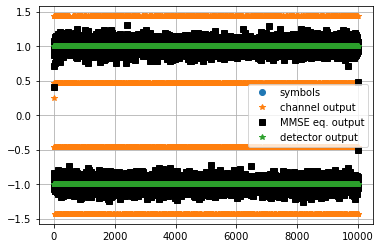

In [3]:
import numpy as np
from scipy import signal
from numpy.random import randint
from scipy.linalg import toeplitz

N = 10000  # length of transmitting sequence
s = (-1) ** (np.floor(2 * np.random.rand(N)))  # creating PAM symbols

Es = np.mean(s**2)
s = s/np.sqrt(Es)

# Sending Through the Channel
h = np.array([0.207, 0.815, 0.207])  # channel with finite impulse response
h = h / np.sqrt(np.sum(h**2))  # normalize impulse response

x = signal.lfilter(h, 1, s)
x = x/np.std(x)

# Adding Noise
SNRdB = 25
σ = np.sqrt(1 / (10 ** (SNRdB / 10)))
n = np.random.normal(0, σ, len(x))
y = x + n

# MMSE Equalization at the Receiver
M = 7
L = 2
xh = mmseEq(y, h, σ**2, M, L)
#xh = np.roll(xh,1)

# Detector (Hard Decisions)
xd = np.zeros(xh.shape, dtype=int)
xd[xh > 0] = 1
xd[xh < 0] = -1

plt.plot(s,'o', label='symbols')
plt.plot(x,'*', label='channel output')
plt.plot(xh,'ks', label='MMSE eq. output')
plt.plot(xd,'*', label='detector output')
plt.legend()
plt.grid()

discard = 10
print('symbols: ', s.astype(int))
print('channel output: ',np.round(x,1))
print('MMSE equalizer output: ',np.round(xh,1))
print('decided symbols: ',xd.astype(int))
print(f'SER = {np.mean((s[discard:-discard]>0)^(y[discard:-discard]>0)):.2e}')
print(f'SER MMSE = {np.mean((s[discard:-discard]>0)^(xd[discard:-discard]>0)):.2e}')

In [124]:
def lms(y, x, Ntaps, μ):
    """
    Apply the LMS (Least Mean Squares) algorithm for equalization.

    Parameters:
        y (ndarray): The received signal.
        x (ndarray): The reference signal.
        Ntaps (int): The number of filter taps.
        μ (float): The LMS step size.

    Returns:
        tuple: A tuple containing:
            - ndarray: The equalized signal.
            - ndarray: The final equalizer filter coefficients.
            - ndarray: The squared error at each iteration.

    """
    # Initialize the equalizer filter coefficients
    h = np.zeros(Ntaps)
    L = len(h)//2 #decision delay
    
    # Apply the LMS algorithm    
    squaredError = np.zeros(y.shape)
    out  = np.zeros(y.shape)
    ind = np.arange(-L,L+1)
    
    y = np.pad(y,(L,L))
    
    # Iterate through each sample of the signal
    for i in range(L, len(y)-L):
        y_vec = y[i+ind][-1::-1]
        
        # Generate the estimated signal using the equalizer filter
        xhat = np.dot(y_vec, h)

        # Compute the error between the estimated signal and the reference signal
        error = x[i-L] - xhat
          
        # Update the filter coefficients using the LMS update rule
        h += μ * y_vec * error  
        
        squaredError[i-L] = error**2
        out[i-L] = xhat
        
    return out, h, squaredError

In [322]:
from numpy.random import normal
from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, lowPassFIR, pnorm, sincInterp
from optic.metrics import signal_power
from optic.plot import eyediagram, pconst


# LMS parameters
Ntaps = 15
μ = 0.001

# select modulation order
constType = 'pam'
M = 2

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# Define constelação    
constSymb = GrayMapping(M, constType)  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(50000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ 
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
SNRdB = 20
σ2 = 1/(10**(SNRdB/10))
σ  = np.sqrt(σ2*SpS)

if constType == 'pam':
    ruido  = normal(0, σ, Namostras)
elif constType == 'qam':
    ruido  = 1/np.sqrt(2)*(normal(0, σ, Namostras) + 1j*normal(0, σ, Namostras))

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
y = sigRx[0::SpS].real

y = y/np.std(y)

# LMS equalizer
xh, h_eq, squaredError = lms(y, symbTx, Ntaps, μ)

# Detector (Hard Decisions)
xd = np.zeros(xh.shape, dtype=int)
xd[xh > 0] = 1
xd[xh < 0] = -1

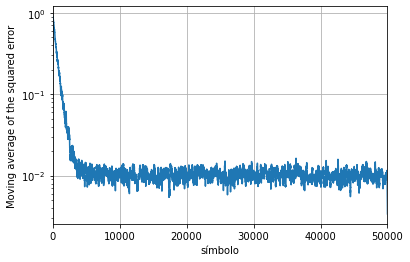

In [323]:
L = 100
MA_SE = np.convolve(np.ones(L)/L, squaredError, 'same')

plt.semilogy(MA_SE);
plt.xlabel('símbolo')
plt.ylabel('Moving average of the squared error')
plt.grid()
plt.xlim(0, len(squaredError));

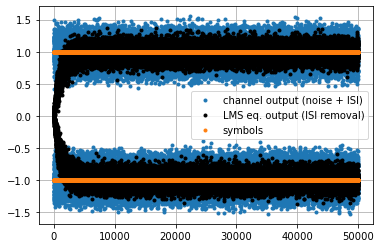

In [324]:
plt.plot(y,'.', label='channel output (noise + ISI)')
plt.plot(xh,'k.', label='LMS eq. output (ISI removal)')
plt.plot(symbTx,'.', label='symbols')
#plt.plot(xd,'.', label='detector output')
plt.legend()
plt.grid()

In [325]:
discard = 1000
print('symbols: ', symbTx.astype(int))
print('channel output: ',np.round(y,1))
print('MMSE equalizer output: ',np.round(xh,1))
print('decided symbols: ',xd.astype(int))
print(f'SER = {np.mean((symbTx[discard:-discard]>0)^(y[discard:-discard]>0)):.2e}')
print(f'SER LMS = {np.mean((symbTx[discard:-discard]>0)^(xd[discard:-discard]>0)):.2e}')

symbols:  [ 1 -1 -1 ... -1  1  1]
channel output:  [ 0.4 -1.  -1.2 ... -1.   1.1  1.1]
MMSE equalizer output:  [ 0.   0.  -0.  ... -1.   1.1  1. ]
decided symbols:  [ 0  1 -1 ... -1  1  1]
SER = 0.00e+00
SER LMS = 0.00e+00


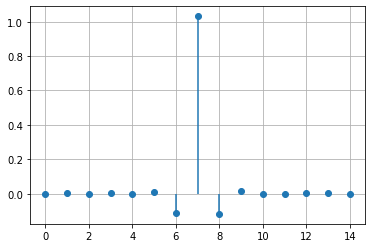

In [326]:
plt.stem(np.arange(Ntaps), h_eq, basefmt=" ");
plt.grid()

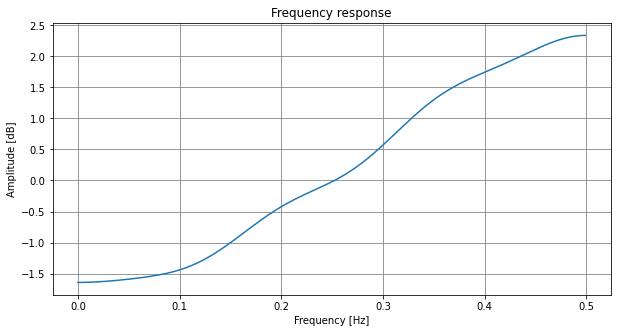

In [327]:
fs = 1
ω, h = signal.freqz(b=h_eq, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.figure(figsize=(10,5))
plt.plot(x, y)
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.title('Frequency response')
plt.grid(which='both', linestyle='-', color='grey')